# IMDB - GloVe with LSTM
> ## NLP(Natural Language Processing)

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Tensorflow

In [2]:
import tensorflow

tensorflow.__version__

'2.9.2'

# I. IMDB Data_Set

> ## 1) wget From Github

* 'IMDB.zip' 파일 다운로드

In [3]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/IMDB.zip

--2023-01-26 07:51:22--  https://raw.githubusercontent.com/rusita-ai/pyData/master/IMDB.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘IMDB.zip’

IMDB.zip            100%[===================>]  57.90M   166MB/s    in 0.3s    

2023-01-26 07:51:26 (166 MB/s) - ‘IMDB.zip’ saved [60711700/60711700]



* 다운로드 결과 확인

In [4]:
!ls -l 

total 59296
-rw-r--r-- 1 root root 60711700 Jan 26 07:51 IMDB.zip
drwxr-xr-x 1 root root     4096 Jan 24 14:38 sample_data


* Unzip 'IMBD.zip'

In [5]:
!unzip -q /content/IMDB.zip

> ## 2) 'texts' and 'labels' Data

* 'texts'  : 문자열 리스트(영화 감상평)
* 'lebels' : 감상평 리뷰(긍정/부정)

In [6]:
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = 'utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [7]:
len(texts), len(labels)

(25000, 25000)

# II. Tensor Transformation

> ## 1) X_train and X_valid : (25000, 2000)

* vectorization
 - (25000, 2000)

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 2000               # 2000개 단어까지 적용
max_words = 10000           # 빈도 높은 10000개 단어 사용

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

# (25000, 2000)으로 패딩
data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)


# 샘플 데이터 랜덤화
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


# 데이터를 훈련 세트와 검증 세트로 분할
training_samples = 15000            # 훈련 샘플은 15000개
validation_samples = 10000          # 검증 샘플은 10000개

X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 2000)
레이블 텐서의 크기: (25000,)


# III. GloVe(Global Vectors for word representation)
* 영문 위키디피아를 사용한 사전 임베딩
* https://nlp.stanford.edu/projects/glove/

> ## 1) wget From Github

* 'glove.6B.50d.zip' 파일 다운로드

In [9]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/glove.6B.50d.zip

--2023-01-26 07:51:47--  https://raw.githubusercontent.com/rusita-ai/pyData/master/glove.6B.50d.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70964402 (68M) [application/zip]
Saving to: ‘glove.6B.50d.zip’

glove.6B.50d.zip    100%[===================>]  67.68M   387MB/s    in 0.2s    

2023-01-26 07:51:52 (387 MB/s) - ‘glove.6B.50d.zip’ saved [70964402/70964402]



* 다운로드 결과 확인

In [10]:
!ls -l 

total 128608
drwxr-xr-x 4 root root     4096 Nov 18  2017 aclImdb
-rw-r--r-- 1 root root 70964402 Jan 26 07:51 glove.6B.50d.zip
-rw-r--r-- 1 root root 60711700 Jan 26 07:51 IMDB.zip
drwxrwxr-x 3 root root     4096 Nov 18  2017 __MACOSX
drwxr-xr-x 1 root root     4096 Jan 24 14:38 sample_data


> ## 1) 'glove.6B.50d.zip' 압축풀기

In [11]:
!unzip -q /content/glove.6B.50d.zip

* 'glove.6B.50d.txt' 확인

In [12]:
!ls -l

total 295944
drwxr-xr-x 4 root root      4096 Nov 18  2017 aclImdb
-rw-r--r-- 1 root root 171350079 Jan 26  2023 glove.6B.50d.txt
-rw-r--r-- 1 root root  70964402 Jan 26 07:51 glove.6B.50d.zip
-rw-r--r-- 1 root root  60711700 Jan 26 07:51 IMDB.zip
drwxrwxr-x 3 root root      4096 Nov 18  2017 __MACOSX
drwxr-xr-x 1 root root      4096 Jan 24 14:38 sample_data


> ## 2) 'glove.6B.50d.txt' 사전 학습 임베딩

* 'glove.6B.50d.txt' 파일 파싱
 - 단어에 매핑되는 표현벡터 인덱스 생성

In [13]:
import numpy as np
import os

glove_dir = '.'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'), encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


* 매핑 확인

In [14]:
embeddings_index['apple'].shape

(50,)

> ## 3) 임베딩 행렬 생성

* (10000, 50)

In [15]:
embedding_dim = 50

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됨
            embedding_matrix[i] = embedding_vector

* 확인

In [16]:
embedding_matrix.shape

(10000, 50)

# IV. Keras Embedding Modeling

> ## 1) Model Define

* 모델 신경망 구조 정의
 - max_words: 10000
 - embedding_dim: 50

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers

imdb = models.Sequential()
imdb.add(layers.Embedding(input_dim = max_words,
                          output_dim = embedding_dim))
imdb.add(layers.Bidirectional(layers.LSTM(16)))
imdb.add(layers.Dense(1, activation = 'sigmoid'))

imdb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          500000    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               8576      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 508,609
Trainable params: 508,609
Non-trainable params: 0
_________________________________________________________________


> ### (1) <font color = 'blue'>GloVe' Embedding Layer Parameter 설정

In [18]:
imdb.layers[0].set_weights([embedding_matrix])

> ### (2) <font color = 'red'>'GloVe' Embedding Layer Parameter 동결

In [19]:
imdb.layers[0].trainable = False

> ### (3) 모델 구조 확인

In [20]:
imdb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          500000    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               8576      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 508,609
Trainable params: 8,609
Non-trainable params: 500,000
_________________________________________________________________


> ## 2) Model Compile

* 모델 학습방법 설정

In [21]:
imdb.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

> ## 3) Model Fit

* 약 11분

In [22]:
%%time

Hist_imdb = imdb.fit(X_train, y_train,
                     epochs = 100,
                     batch_size = 512,
                     validation_data = (X_valid, y_valid))

Epoch 1/100
30/30 [==============================] - 14s 223ms/step - loss: 0.6895 - accuracy: 0.5335 - val_loss: 0.6825 - val_accuracy: 0.5662
Epoch 2/100
30/30 [==============================] - 6s 195ms/step - loss: 0.6725 - accuracy: 0.5959 - val_loss: 0.6514 - val_accuracy: 0.6385
Epoch 3/100
30/30 [==============================] - 6s 192ms/step - loss: 0.6345 - accuracy: 0.6539 - val_loss: 0.6207 - val_accuracy: 0.6699
Epoch 4/100
30/30 [==============================] - 6s 196ms/step - loss: 0.6091 - accuracy: 0.6826 - val_loss: 0.5982 - val_accuracy: 0.6935
Epoch 5/100
30/30 [==============================] - 6s 193ms/step - loss: 0.5989 - accuracy: 0.6911 - val_loss: 0.5767 - val_accuracy: 0.7116
Epoch 6/100
30/30 [==============================] - 7s 225ms/step - loss: 0.5966 - accuracy: 0.6807 - val_loss: 0.6471 - val_accuracy: 0.5933
Epoch 7/100
30/30 [==============================] - 6s 194ms/step - loss: 0.6038 - accuracy: 0.6799 - val_loss: 0.5715 - val_accuracy: 0.725

> ## 4) 학습 결과 시각화

* Loss & Accuracy Visualization

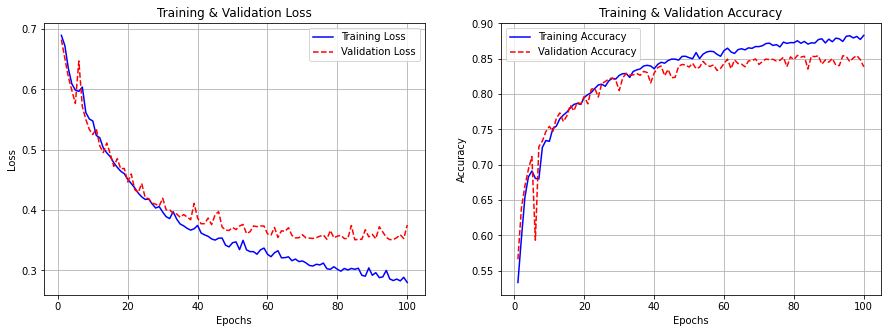

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_imdb.history['loss']) + 1)

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_imdb.history['loss'], 'b-')
plt.plot(epochs, Hist_imdb.history['val_loss'], 'r--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_imdb.history['accuracy'], 'b-')
plt.plot(epochs, Hist_imdb.history['val_accuracy'], 'r--')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()

plt.show()

> ## 5) Model Evaluate

* Loss & Accuracy

In [24]:
loss, accuracy = imdb.evaluate(X_valid, y_valid, verbose = 0)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Loss = 0.37523
Accuracy = 0.83860


# 
# 
# 
# The End
# 
# 
# 